In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.3.1')

In [2]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [3]:
df = pd.read_parquet(f"{SCRATCH_DIR}/model_selection_all_delays_ORD_UA.parquet")

df.head()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,Dest,NAME,CERTIFICATION,engine_type,engine_manufacturer,engine_model,aircraft_type,aircraft_manufacturer,aircraft_model,delayed
25272188,1,1,22,2,1315,1932,257,1846,8,2001.0,...,ORD,WELLS FARGO TRUST CO NA TRUSTEE ...,1T,5,ROLLS-ROYCE,RB-211 SERIES,5,BOEING,757-33N,True
25272196,1,1,22,2,1000,1144,164,733,3,2002.0,...,ORD,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B22,5,BOEING,737-700,False
25272197,1,1,22,2,1430,1650,80,296,2,2015.0,...,CMH,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B27E,5,BOEING,737-924ER,True
25272202,1,1,22,2,1011,1200,169,888,4,2004.0,...,DEN,UNITED AIRLINES INC ...,1T,5,ROLLS-ROYCE,RB-211 SERIES,5,BOEING,757-324,True
25272222,1,1,22,2,1423,2024,241,1723,7,2004.0,...,ORD,UMB BANK NA TRUSTEE ...,1T,5,CFM INTL,CFM56 SERIES,5,BOEING,737-824,True


In [4]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Tail_Number",
    "Origin",
    "Dest",
    "NAME",
    "CERTIFICATION",
    "engine_type",
    "engine_manufacturer",
    "engine_model",
    "aircraft_type",
    "aircraft_manufacturer",
    "aircraft_model",
]

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC


start_time = time.time()

# No need to use the ordinal encoder for CatBoost when using
# the cat_features parameter but we need to do some other preprocessing.
#
# CatBoost is converting True/False into string values for some reason
# casting the labels as 1/0 ints here
X = df.drop("delayed", axis=1)
y = df["delayed"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_indices = [X.columns.get_loc(col) for col in cat_cols]

smotenc = SMOTENC(
    categorical_features=cat_indices, sampling_strategy="auto", random_state=42
)
X_res, y_res = smotenc.fit_resample(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

print(" Original:", X_train.shape, y_train.shape)
print("Resampled:", X_res.shape, y_res.shape)

Elapsed time: 496.9891 seconds
 Original: (122848, 28) (122848,)
Resampled: (182596, 28) (182596,)


In [6]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier


def fit_grid_search(fit_X_train, fit_y_train):
    cat_classifier = CatBoostClassifier(
        eval_metric="F1",
        auto_class_weights="Balanced",
        cat_features=cat_indices,
        verbose=0,
    )

    grid_search = GridSearchCV(
        cat_classifier,
        param_grid={},
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END ..................................., score=0.930 total time=10.3min
[CV 5/5] END ..................................., score=0.932 total time=10.2min
[CV 4/5] END ..................................., score=0.926 total time=10.2min
[CV 2/5] END ..................................., score=0.689 total time=10.3min
[CV 1/5] END ..................................., score=0.507 total time=10.3min
Elapsed time: 763.0280 seconds


In [7]:
# Checkpoint

MODEL = "model_selection_all_delays_ORD_UA_catboost_SMOTENC"
MODEL_NAME = "Cat Boost (SMOTENC)"

with open(f"{SCRATCH_DIR}/{MODEL}.pkl", "wb") as f:
    pickle.dump(model, f)

# So we can recompute the metrics later
with open(f"{SCRATCH_DIR}/{MODEL}_X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open(f"{SCRATCH_DIR}/{MODEL}_y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

# It takes a long time to resample with SMOTENC, so stash these too.
with open(f"{SCRATCH_DIR}/{MODEL}_X_res.pkl", "wb") as f:
    pickle.dump(X_res, f)
with open(f"{SCRATCH_DIR}/{MODEL}_y_res.pkl", "wb") as f:
    pickle.dump(y_res, f)

# with open(f"{SCRATCH_DIR}/{MODEL}.pkl", "rb") as f:
#     model = pickle.load(f)

# Model Evaluation

In [8]:
print("Best parameters: ", model.best_params_)
print("Best score: ", model.best_score_)

model.cv_results_

Best parameters:  {}
Best score:  0.7967482870748416


{'mean_fit_time': array([614.19936914]),
 'std_fit_time': array([0.84474899]),
 'mean_score_time': array([1.34992285]),
 'std_score_time': array([0.03080372]),
 'params': [{}],
 'split0_test_score': array([0.50726153]),
 'split1_test_score': array([0.68888067]),
 'split2_test_score': array([0.9296628]),
 'split3_test_score': array([0.92567497]),
 'split4_test_score': array([0.93226147]),
 'mean_test_score': array([0.79674829]),
 'std_test_score': array([0.17209892]),
 'rank_test_score': array([1], dtype=int32)}

In [9]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
)


y_pred = model.predict(X_test)

[[20801  2058]
 [ 5505  2348]]


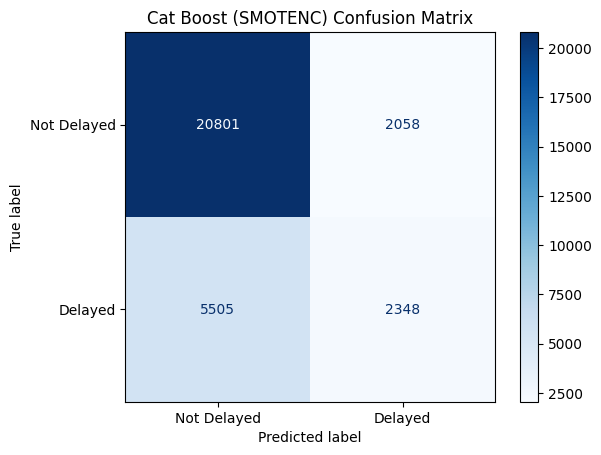

In [10]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title(f"{MODEL_NAME} Confusion Matrix")

plt.savefig(f"{SCRATCH_DIR}/visualizations/{MODEL}_cm.png")

plt.show()


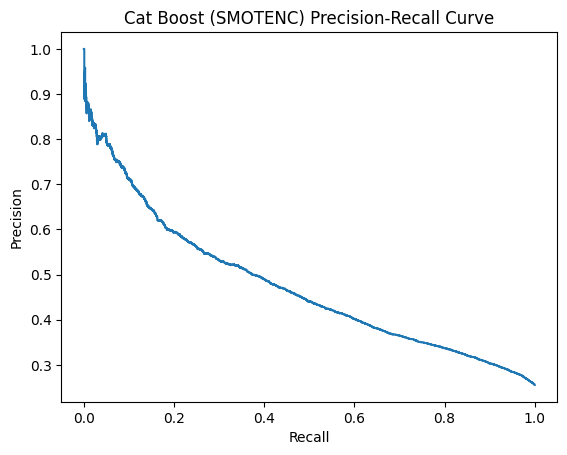

In [11]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{MODEL_NAME} Precision-Recall Curve")

plt.savefig(f"{SCRATCH_DIR}/visualizations/{MODEL}_pr.png")

plt.show()

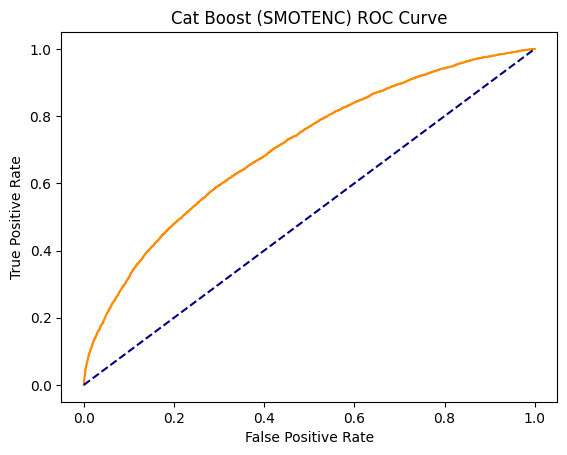

In [12]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{MODEL_NAME} ROC Curve")

plt.savefig(f"{SCRATCH_DIR}/visualizations/{MODEL}_roc.png")

plt.show()

In [13]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

accuracy, precision, recall, f1, roc_auc

(0.7537444647043501,
 0.5329096686336814,
 0.2989940150261047,
 0.38306550289583163,
 0.6044819149893199)

In [14]:
metrics_scores = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

base = alt.Chart(df_metrics).encode(
    y=alt.Y("Metric:N", axis=alt.Axis(title="Metric"), sort=df_metrics["Metric"].values),
    x=alt.X("Score:Q", axis=alt.Axis(title="Score"), scale=alt.Scale(domain=[0, 1])),
)

bar = base.mark_bar().encode(
    color=alt.Color("Metric:N", legend=None), text=alt.Text("Score:Q", format=".2f")
)

text = base.mark_text(
    align="right",
    baseline="middle",
    color="white",
    dx=-10,
).encode(text=alt.Text("Score:Q", format=".2f"))

chart = (
    (bar + text)
    .properties(title=f"{MODEL_NAME} Evaluation Metrics", width=600, height=300)
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

# Can't get this one to save programmatically :(
# from altair_saver import save
# chart.save(f"{SCRATCH_DIR}/visualizations/{MODEL}_metrics.png")
# save(chart, f"{SCRATCH_DIR}/visualizations/{MODEL}_metrics.png")

chart

alt.LayerChart(...)